In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

We've decided to combine the whole data to avoid cycles. Then we've calculated the correlations and sorted them in decreasing order. Two pairs that will be used are: THYAO-PGSUS and GARAN-AKBNK.

In [3]:

directory_path =  r'C:\Users\kutay\Downloads\20180101_20231121_bist30'

# Get a list of all CSV files in the specified directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store DataFrames for each CSV file
dataframes = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Pivot the dataframe to have stock names as columns and timestamps as index
pivot_df = combined_df.pivot(index='timestamp', columns='short_name', values='price')

In [4]:
# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Print the correlation matrix for debugging
print("Correlation Matrix:")
print(correlation_matrix)

# Sort the correlation matrix in descending order
sorted_correlation_matrix = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Print only values where correlation is not equal to 1
filtered_sorted_correlation_matrix = sorted_correlation_matrix[sorted_correlation_matrix != 1]
print("Sorted Correlation Matrix (excluding 1):")
print(filtered_sorted_correlation_matrix)

Correlation Matrix:
short_name     AKBNK     ARCLK     ASELS     BIMAS     DOHOL     EKGYO  \
short_name                                                               
AKBNK       1.000000  0.927587  0.960334  0.956508  0.952171  0.917057   
ARCLK       0.927587  1.000000  0.966464  0.945000  0.973363  0.948539   
ASELS       0.960334  0.966464  1.000000  0.960527  0.984010  0.962343   
BIMAS       0.956508  0.945000  0.960527  1.000000  0.969865  0.889897   
DOHOL       0.952171  0.973363  0.984010  0.969865  1.000000  0.958506   
EKGYO       0.917057  0.948539  0.962343  0.889897  0.958506  1.000000   
EREGL       0.782771  0.939471  0.868432  0.835067  0.876864  0.873429   
FROTO       0.941891  0.985567  0.969425  0.963755  0.980477  0.939187   
GARAN       0.992619  0.938193  0.956771  0.967780  0.956934  0.913215   
GUBRF       0.928498  0.969483  0.978174  0.954977  0.988038  0.959544   
HALKB       0.892488  0.774272  0.845410  0.766697  0.805406  0.871442   
ISCTR       0.9874

In [5]:

combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Select the relevant pairs (THYAO and PGSUS)
thyao_df = combined_df[combined_df['short_name'] == 'THYAO']
pgsus_df = combined_df[combined_df['short_name'] == 'PGSUS']
print(thyao_df)
print(pgsus_df)

                       timestamp   price short_name
0      2018-01-02 09:00:00+03:00   15.79      THYAO
1      2018-01-02 10:00:00+03:00   16.01      THYAO
2      2018-01-02 11:00:00+03:00   16.05      THYAO
3      2018-01-02 12:00:00+03:00   16.05      THYAO
4      2018-01-02 13:00:00+03:00   16.06      THYAO
...                          ...     ...        ...
427092 2023-11-21 09:00:00+03:00  256.00      THYAO
427093 2023-11-21 10:00:00+03:00  255.00      THYAO
427094 2023-11-21 11:00:00+03:00  257.75      THYAO
427095 2023-11-21 12:00:00+03:00  258.25      THYAO
427096 2023-11-21 13:00:00+03:00  258.25      THYAO

[14642 rows x 3 columns]
                       timestamp   price short_name
9600   2018-01-02 09:00:00+03:00   33.98      PGSUS
9601   2018-01-02 10:00:00+03:00   34.28      PGSUS
9602   2018-01-02 11:00:00+03:00   35.02      PGSUS
9603   2018-01-02 12:00:00+03:00   35.10      PGSUS
9604   2018-01-02 13:00:00+03:00   35.08      PGSUS
...                          ...     .

In [6]:

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(thyao_df[['timestamp', 'price']], pgsus_df[['timestamp', 'price']], on='timestamp', suffixes=('_THYAO', '_PGSUS'))
print(merged_df)

                      timestamp  price_THYAO  price_PGSUS
0     2018-01-02 09:00:00+03:00        15.79        33.98
1     2018-01-02 10:00:00+03:00        16.01        34.28
2     2018-01-02 11:00:00+03:00        16.05        35.02
3     2018-01-02 12:00:00+03:00        16.05        35.10
4     2018-01-02 13:00:00+03:00        16.06        35.08
...                         ...          ...          ...
14632 2023-11-21 09:00:00+03:00       256.00       747.00
14633 2023-11-21 10:00:00+03:00       255.00       737.00
14634 2023-11-21 11:00:00+03:00       257.75       741.50
14635 2023-11-21 12:00:00+03:00       258.25       744.00
14636 2023-11-21 13:00:00+03:00       258.25       742.50

[14637 rows x 3 columns]


Then, we've applied linear regression by setting the price of THYAO (Y) as independent variable and the price of PGSUS (X) as the dependent variable. Then, we multiplied the regression coefficient (ß1) with dependent variable X and subtracted it from independent variable Y to calculate the residuals.

In [7]:
# Extract independent and dependent variables
X = merged_df[['price_THYAO']]
y = merged_df['price_PGSUS']
# Add a constant term to the independent variable (required for statsmodels)
X = sm.add_constant(X)

# Fit a linear regression model using statsmodels
model = sm.OLS(y, X).fit()
residuals = y - model.predict(X)
# Print the detailed regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price_PGSUS   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.040e+06
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:36:40   Log-Likelihood:                -68217.
No. Observations:               14637   AIC:                         1.364e+05
Df Residuals:                   14635   BIC:                         1.365e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0603      0.263     19.253      

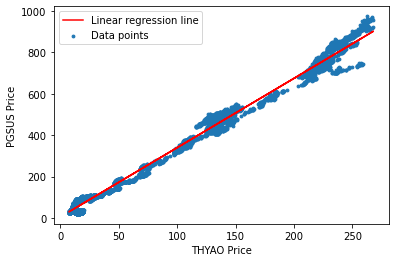

In [8]:
# Plot the regression line
plt.scatter(X['price_THYAO'], y, label='Data points',s=8)
plt.plot(X['price_THYAO'], model.predict(X), color='red', label='Linear regression line')
plt.xlabel('THYAO Price')
plt.ylabel('PGSUS Price')
plt.legend()
plt.show()

For the constant variance assumption, we need to check residuals vs predicted values plot. If there's a pattern, then it means that assumption does not hold so we need to do variance stabilizing transformation.

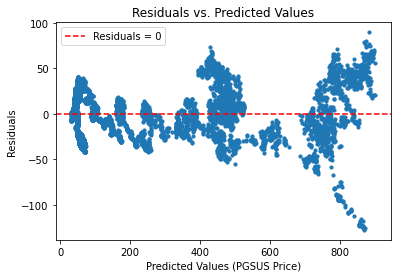

In [9]:
plt.scatter(model.predict(X), residuals, s=10)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Values (PGSUS Price)')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals vs. Predicted Values')
plt.show()

We see that there's a pattern, so constant variance assumption does not hold. We've tried natural logarithm function next:

                            OLS Regression Results                            
Dep. Variable:            price_PGSUS   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 7.343e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:36:43   Log-Likelihood:                -8316.8
No. Observations:               14637   AIC:                         1.664e+04
Df Residuals:                   14635   BIC:                         1.665e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3799      0.012    115.704      

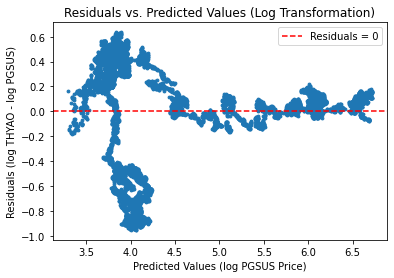

In [10]:
combined_df = pd.concat(dataframes, ignore_index=True)

# Select the relevant pairs (THYAO and PGSUS)
thyao_df = combined_df[combined_df['short_name'] == 'THYAO']
pgsus_df = combined_df[combined_df['short_name'] == 'PGSUS']

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(thyao_df[['timestamp', 'price']], pgsus_df[['timestamp', 'price']], on='timestamp', suffixes=('_THYAO', '_PGSUS'))

# Extract independent and dependent variables
X = merged_df[['price_THYAO']]
y = merged_df['price_PGSUS']

# Take the natural logarithm of both variables
X_log = np.log(X)
y_log = np.log(y)

# Add a constant term to the independent variable (required for statsmodels)
X_log = sm.add_constant(X_log)

# Fit a linear regression model using statsmodels
model_log = sm.OLS(y_log, X_log).fit()

# Print the detailed regression summary
print(model_log.summary())

# Plot residuals vs. predicted values
residuals_log = y_log - model_log.predict(X_log)

plt.scatter(model_log.predict(X_log), residuals_log, s=8)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Values (log PGSUS Price)')
plt.ylabel('Residuals (log THYAO - log PGSUS)')
plt.legend()
plt.title('Residuals vs. Predicted Values (Log Transformation)')
plt.show()

Again, there's a pattern so constant variance assumption does not hold. Lastly, we've tried log returns:

In [11]:

#The constant variance assumption does not hold! We need variance stabilizing transformation.


# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Select the relevant pairs (THYAO and PGSUS)
thyao_df = combined_df[combined_df['short_name'] == 'THYAO']
pgsus_df = combined_df[combined_df['short_name'] == 'PGSUS']

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(thyao_df[['timestamp', 'price']], pgsus_df[['timestamp', 'price']], on='timestamp', suffixes=('_THYAO', '_PGSUS'))


In [12]:

# Calculate log returns
merged_df['log_return_THYAO'] = np.log(merged_df['price_THYAO'] / merged_df['price_THYAO'].shift(1))
merged_df['log_return_PGSUS'] = np.log(merged_df['price_PGSUS'] / merged_df['price_PGSUS'].shift(1))

# Drop NaN values introduced by the log returns calculation
merged_df = merged_df.dropna()


                            OLS Regression Results                            
Dep. Variable:       log_return_PGSUS   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                 1.254e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:36:46   Log-Likelihood:                 50852.
No. Observations:               14636   AIC:                        -1.017e+05
Df Residuals:                   14634   BIC:                        -1.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5.263e-05    6.2e-05  

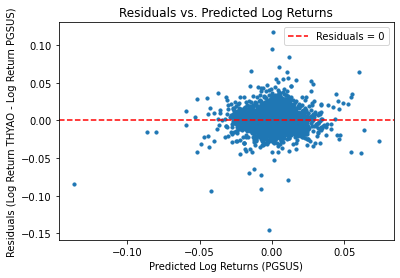

In [13]:

# Extract independent and dependent variables
X_log_return = merged_df[['log_return_THYAO']]
y_log_return = merged_df['log_return_PGSUS']

# Add a constant term to the independent variable (required for statsmodels)
X_log_return = sm.add_constant(X_log_return)

# Fit a linear regression model using statsmodels
model_log_return = sm.OLS(y_log_return, X_log_return).fit()
print(model_log_return.summary())
residuals_log_return = y_log_return - model_log_return.predict(X_log_return)

plt.scatter(model_log_return.predict(X_log_return), residuals_log_return, s=10)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Log Returns (PGSUS)')
plt.ylabel('Residuals (Log Return THYAO - Log Return PGSUS)')
plt.legend()
plt.title('Residuals vs. Predicted Log Returns')
plt.show()

There is no pattern so we can continue with the log return transformation and move on to the control chart and pair trading algorithm. For the control chart, we've created a 1 sigma control chart for the residuals. For the pairs trading algorithm, we've started the process by buying both of the stocks for capital of 1000 Turkish Liras for each stocks. When residuals go beyond the upper control limits, we've sold all of the THYAO and bought PGSUS with all of the money. When residuals pass the central line, we've sold half of the PGSUS and bought THYAO back. The same logic is applied reversely for lower control limit.

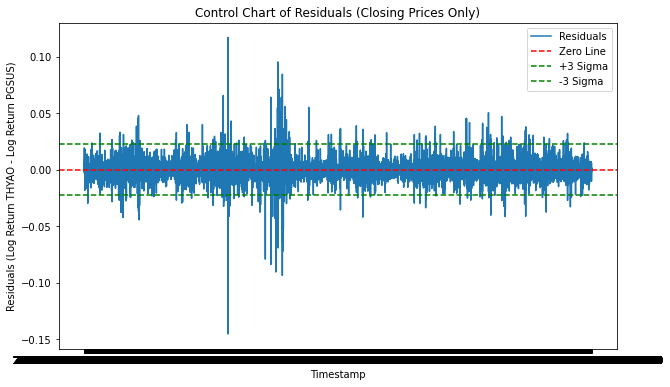

In [15]:

# Calculate standard deviation of residuals
sigma = np.std(residuals_log_return)
plt.figure(figsize=(10, 6))
plt.plot(merged_df['timestamp'], residuals_log_return, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.axhline(y=3*sigma, color='green', linestyle='--', label='+3 Sigma')
plt.axhline(y=-3*sigma, color='green', linestyle='--', label='-3 Sigma')
plt.xlabel('Timestamp')
plt.ylabel('Residuals (Log Return THYAO - Log Return PGSUS)')
plt.title('Control Chart of Residuals (Closing Prices Only)')
plt.legend()
plt.show()

In [16]:
# Pairs trading algorithm
# Set initial capital
# Initialize lists to store results
timestamp_list = []
capital_list_thyao = []
capital_list_pgsus = []
initial_capital_thyao = 1000
initial_capital_pgsus = 1000
positions_thyao = initial_capital_thyao / merged_df['price_THYAO'].iloc[0]
positions_pgsus = initial_capital_pgsus / merged_df['price_PGSUS'].iloc[0]
print("Number of THYAO Stocks at the beginning:",positions_thyao)
print("Number of PGSUS Stocks at the beginning:",positions_pgsus)
capital_thyao=1000
capital_pgsus=1000
capital_thyao=1000/merged_df['price_THYAO'].iloc[1]
capital_pgsus=1000/merged_df['price_PGSUS'].iloc[1]

for i in range(1, len(merged_df)):

    capital_thyao=merged_df['price_THYAO'].iloc[i]*positions_thyao
    capital_pgsus=merged_df['price_PGSUS'].iloc[i]*positions_pgsus

    timestamp_list.append(merged_df['timestamp'].iloc[i])
    residual = residuals_log_return.iloc[i - 1]

    
    

    # Sell THYAO and buy more PGSUS
    if residual > 1 * sigma:
        positions_thyao = 0
        positions_pgsus += capital_thyao / merged_df['price_PGSUS'].iloc[i]
        capital_thyao = 0
    # Sell PGSUS and buy more THYAO
    elif residual < -1 * sigma:

        positions_pgsus = 0
        positions_thyao += capital_pgsus / merged_df['price_THYAO'].iloc[i]
        capital_pgsus = 0


    # Buy back THYAO with half of the money
    # Sell half of the existing THYAO positions and buy PGSUS with that money
    elif residuals_log_return.iloc[i - 2]<=0 and residuals_log_return.iloc[i - 1]>=0 and positions_thyao > 0:

        sold_thyao = positions_thyao / 2
        positions_pgsus += (capital_thyao / 2) / merged_df['price_PGSUS'].iloc[i]
        positions_thyao -= sold_thyao
        capital_thyao -= sold_thyao * merged_df['price_THYAO'].iloc[i]
        capital_pgsus += (capital_thyao)

    # Sell half of the existing PGSUS positions and buy THYAO with that money
    elif residuals_log_return.iloc[i - 2]>=0 and residuals_log_return.iloc[i - 1]<=0 and positions_pgsus > 0:   
        sold_pgsus = positions_pgsus / 2
        positions_thyao += (capital_pgsus / 2) / merged_df['price_THYAO'].iloc[i]
        positions_pgsus -= sold_pgsus
        capital_pgsus -= sold_pgsus * merged_df['price_PGSUS'].iloc[i]
        capital_thyao += (capital_pgsus)

    # Hold the position if residuals are within control limits
    else:

        pass

    # Calculate capital for each time unit
    current_capital_thyao = positions_thyao * merged_df['price_THYAO'].iloc[i]
    current_capital_pgsus = positions_pgsus * merged_df['price_PGSUS'].iloc[i]

    capital_list_thyao.append(current_capital_thyao)
    capital_list_pgsus.append(current_capital_pgsus)



Number of THYAO Stocks at the beginning: 62.46096189881324
Number of PGSUS Stocks at the beginning: 29.171528588098017


In [17]:
print("Total money after applying the algorithm:",capital_list_thyao[-1]+capital_list_pgsus[-1])



Total money after applying the algorithm: 43481.8438782593


Then we've calculated the earnings without applying the algorithm with the same capital in order to see the performance the algorithm.

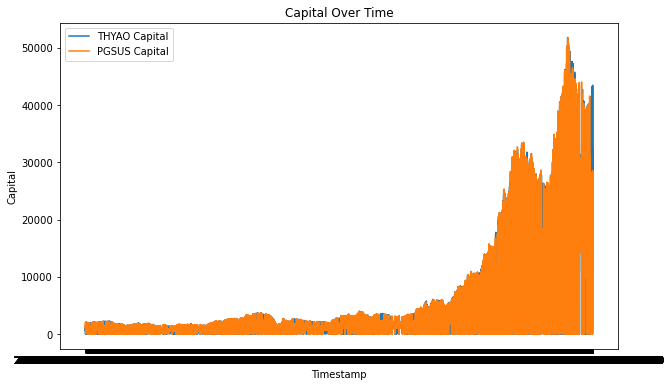

In [18]:
# Plot capital for each time unit
plt.figure(figsize=(10, 6))
plt.plot(timestamp_list, capital_list_thyao, label='THYAO Capital')
plt.plot(timestamp_list, capital_list_pgsus, label='PGSUS Capital')
plt.xlabel('Timestamp')
plt.ylabel('Capital')
plt.title('Capital Over Time')
plt.legend()
plt.show()

In [19]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Initial capital for the portfolio
initial_capital = 1000

# Initial positions for each stock
initial_positions_thyao = initial_capital / combined_df[combined_df['short_name'] == 'THYAO']['price'].iloc[0]
initial_positions_pgsus = initial_capital / combined_df[combined_df['short_name'] == 'PGSUS']['price'].iloc[0]


# Iterate through the dataframe and update positions and capital

value_thyao = initial_positions_thyao * combined_df[combined_df['short_name'] == 'THYAO']['price'].iloc[-1]
value_pgsus = initial_positions_pgsus * combined_df[combined_df['short_name'] == 'PGSUS']['price'].iloc[-1]
    

print("Total money without applying the algorithm:",value_pgsus+value_thyao)

Total money without applying the algorithm: 38206.37703287073


The pairs trading algorithm increases the earnings if the control limits (k*sigma) are chosen under a certain value. If k is chosen a high constant (>3), the outcome will be close to the earning similar to that of not applying the pairs trading algorithm. When we set k equal to 1, pairs trading algorithm increases the earnings around 5275 which is 2.6375 Turkish Liras times of the initial capital (2000 TL) since the algorithm enables us to avoid unnecesarry risks in the market.

Pair 2: GARAN-AKBNK

In [20]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

We've decided to combine the whole data to avoid cycles. Then we've calculated the correlations and sorted them in decreasing order. Two pairs that will be used are: THYAO-PGSUS and GARAN-AKBNK.

In [21]:

directory_path =  r'C:\Users\kutay\Downloads\20180101_20231121_bist30'

# Get a list of all CSV files in the specified directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store DataFrames for each CSV file
dataframes = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Pivot the dataframe to have stock names as columns and timestamps as index
pivot_df = combined_df.pivot(index='timestamp', columns='short_name', values='price')

In [22]:
# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Print the correlation matrix for debugging
print("Correlation Matrix:")
print(correlation_matrix)

# Sort the correlation matrix in descending order
sorted_correlation_matrix = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Print only values where correlation is not equal to 1
filtered_sorted_correlation_matrix = sorted_correlation_matrix[sorted_correlation_matrix != 1]
print("Sorted Correlation Matrix (excluding 1):")
print(filtered_sorted_correlation_matrix)

Correlation Matrix:
short_name     AKBNK     ARCLK     ASELS     BIMAS     DOHOL     EKGYO  \
short_name                                                               
AKBNK       1.000000  0.927587  0.960334  0.956508  0.952171  0.917057   
ARCLK       0.927587  1.000000  0.966464  0.945000  0.973363  0.948539   
ASELS       0.960334  0.966464  1.000000  0.960527  0.984010  0.962343   
BIMAS       0.956508  0.945000  0.960527  1.000000  0.969865  0.889897   
DOHOL       0.952171  0.973363  0.984010  0.969865  1.000000  0.958506   
EKGYO       0.917057  0.948539  0.962343  0.889897  0.958506  1.000000   
EREGL       0.782771  0.939471  0.868432  0.835067  0.876864  0.873429   
FROTO       0.941891  0.985567  0.969425  0.963755  0.980477  0.939187   
GARAN       0.992619  0.938193  0.956771  0.967780  0.956934  0.913215   
GUBRF       0.928498  0.969483  0.978174  0.954977  0.988038  0.959544   
HALKB       0.892488  0.774272  0.845410  0.766697  0.805406  0.871442   
ISCTR       0.9874

In [23]:

combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Select the relevant pairs (GARAN and AKBNK)
GARAN_df = combined_df[combined_df['short_name'] == 'GARAN']
AKBNK_df = combined_df[combined_df['short_name'] == 'AKBNK']
print(GARAN_df)
print(AKBNK_df)

                       timestamp    price short_name
6400   2018-01-02 09:00:00+03:00   9.2047      GARAN
6401   2018-01-02 10:00:00+03:00   9.3157      GARAN
6402   2018-01-02 11:00:00+03:00   9.3414      GARAN
6403   2018-01-02 12:00:00+03:00   9.3242      GARAN
6404   2018-01-02 13:00:00+03:00   9.3328      GARAN
...                          ...      ...        ...
431242 2023-11-21 09:00:00+03:00  49.0000      GARAN
431243 2023-11-21 10:00:00+03:00  49.0600      GARAN
431244 2023-11-21 11:00:00+03:00  48.7600      GARAN
431245 2023-11-21 12:00:00+03:00  48.6800      GARAN
431246 2023-11-21 13:00:00+03:00  48.5800      GARAN

[14642 rows x 3 columns]
                       timestamp    price short_name
640    2018-01-02 09:00:00+03:00   6.9475      AKBNK
641    2018-01-02 10:00:00+03:00   7.0602      AKBNK
642    2018-01-02 11:00:00+03:00   7.0954      AKBNK
643    2018-01-02 12:00:00+03:00   7.0814      AKBNK
644    2018-01-02 13:00:00+03:00   7.1024      AKBNK
...                 

In [24]:

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(GARAN_df[['timestamp', 'price']], AKBNK_df[['timestamp', 'price']], on='timestamp', suffixes=('_GARAN', '_AKBNK'))
print(merged_df)

                      timestamp  price_GARAN  price_AKBNK
0     2018-01-02 09:00:00+03:00       9.2047       6.9475
1     2018-01-02 10:00:00+03:00       9.3157       7.0602
2     2018-01-02 11:00:00+03:00       9.3414       7.0954
3     2018-01-02 12:00:00+03:00       9.3242       7.0814
4     2018-01-02 13:00:00+03:00       9.3328       7.1024
...                         ...          ...          ...
14637 2023-11-21 09:00:00+03:00      49.0000      30.6800
14638 2023-11-21 10:00:00+03:00      49.0600      30.4800
14639 2023-11-21 11:00:00+03:00      48.7600      30.4800
14640 2023-11-21 12:00:00+03:00      48.6800      30.5000
14641 2023-11-21 13:00:00+03:00      48.5800      30.4600

[14642 rows x 3 columns]


Then, we've applied linear regression by setting the price of GARAN (Y) as independent variable and the price of AKBNK (X) as the dependent variable. Then, we multiplied the regression coefficient (ß1) with dependent variable X and subtracted it from independent variable Y to calculate the residuals.

In [25]:
# Extract independent and dependent variables
X = merged_df[['price_GARAN']]
y = merged_df['price_AKBNK']
# Add a constant term to the independent variable (required for statsmodels)
X = sm.add_constant(X)

# Fit a linear regression model using statsmodels
model = sm.OLS(y, X).fit()
residuals = y - model.predict(X)
# Print the detailed regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price_AKBNK   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 9.807e+05
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:49:51   Log-Likelihood:                -17585.
No. Observations:               14642   AIC:                         3.517e+04
Df Residuals:                   14640   BIC:                         3.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6980      0.011     66.398      

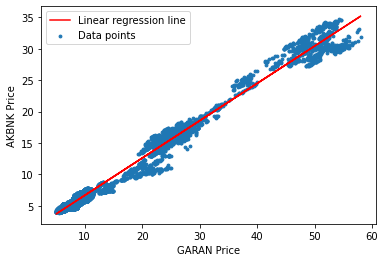

In [26]:
# Plot the regression line
plt.scatter(X['price_GARAN'], y, label='Data points',s=8)
plt.plot(X['price_GARAN'], model.predict(X), color='red', label='Linear regression line')
plt.xlabel('GARAN Price')
plt.ylabel('AKBNK Price')
plt.legend()
plt.show()

For the constant variance assumption, we need to check residuals vs predicted values plot. If there's a pattern, then it means that assumption does not hold so we need to do variance stabilizing transformation.

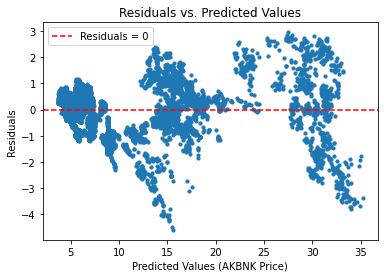

In [27]:
plt.scatter(model.predict(X), residuals, s=10)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Values (AKBNK Price)')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals vs. Predicted Values')
plt.show()

We see that there's a pattern, so constant variance assumption does not hold. We've tried natural logarithm function next:

                            OLS Regression Results                            
Dep. Variable:            price_AKBNK   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 4.873e+05
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:49:53   Log-Likelihood:                 14210.
No. Observations:               14642   AIC:                        -2.842e+04
Df Residuals:                   14640   BIC:                        -2.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1893      0.003    -58.908      

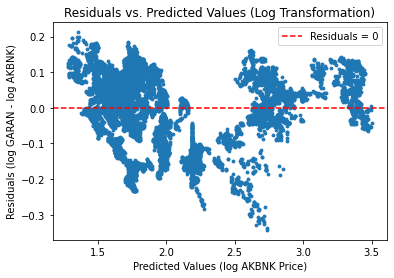

In [28]:
combined_df = pd.concat(dataframes, ignore_index=True)

# Select the relevant pairs (GARAN and AKBNK)
GARAN_df = combined_df[combined_df['short_name'] == 'GARAN']
AKBNK_df = combined_df[combined_df['short_name'] == 'AKBNK']

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(GARAN_df[['timestamp', 'price']], AKBNK_df[['timestamp', 'price']], on='timestamp', suffixes=('_GARAN', '_AKBNK'))

# Extract independent and dependent variables
X = merged_df[['price_GARAN']]
y = merged_df['price_AKBNK']

# Take the natural logarithm of both variables
X_log = np.log(X)
y_log = np.log(y)

# Add a constant term to the independent variable (required for statsmodels)
X_log = sm.add_constant(X_log)

# Fit a linear regression model using statsmodels
model_log = sm.OLS(y_log, X_log).fit()

# Print the detailed regression summary
print(model_log.summary())

# Plot residuals vs. predicted values
residuals_log = y_log - model_log.predict(X_log)

plt.scatter(model_log.predict(X_log), residuals_log, s=8)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Values (log AKBNK Price)')
plt.ylabel('Residuals (log GARAN - log AKBNK)')
plt.legend()
plt.title('Residuals vs. Predicted Values (Log Transformation)')
plt.show()

Again, there's a pattern so constant variance assumption does not hold. Lastly, we've tried log returns:

In [29]:

#The constant variance assumption does not hold! We need variance stabilizing transformation.


# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Select the relevant pairs (GARAN and AKBNK)
GARAN_df = combined_df[combined_df['short_name'] == 'GARAN']
AKBNK_df = combined_df[combined_df['short_name'] == 'AKBNK']

# Merge the two dataframes based on the timestamp
merged_df = pd.merge(GARAN_df[['timestamp', 'price']], AKBNK_df[['timestamp', 'price']], on='timestamp', suffixes=('_GARAN', '_AKBNK'))


In [30]:

# Calculate log returns
merged_df['log_return_GARAN'] = np.log(merged_df['price_GARAN'] / merged_df['price_GARAN'].shift(1))
merged_df['log_return_AKBNK'] = np.log(merged_df['price_AKBNK'] / merged_df['price_AKBNK'].shift(1))

# Drop NaN values introduced by the log returns calculation
merged_df = merged_df.dropna()


                            OLS Regression Results                            
Dep. Variable:       log_return_AKBNK   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 3.098e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:49:53   Log-Likelihood:                 57365.
No. Observations:               14641   AIC:                        -1.147e+05
Df Residuals:                   14639   BIC:                        -1.147e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.059e-06   3.98e-05  

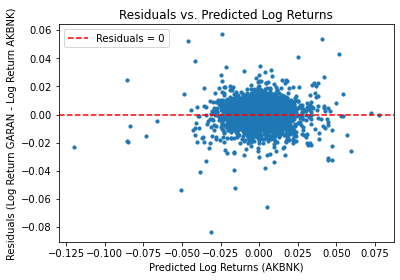

In [31]:

# Extract independent and dependent variables
X_log_return = merged_df[['log_return_GARAN']]
y_log_return = merged_df['log_return_AKBNK']

# Add a constant term to the independent variable (required for statsmodels)
X_log_return = sm.add_constant(X_log_return)

# Fit a linear regression model using statsmodels
model_log_return = sm.OLS(y_log_return, X_log_return).fit()
print(model_log_return.summary())
residuals_log_return = y_log_return - model_log_return.predict(X_log_return)

plt.scatter(model_log_return.predict(X_log_return), residuals_log_return, s=10)  # Adjust the size (s) as needed
plt.axhline(y=0, color='red', linestyle='--', label='Residuals = 0')
plt.xlabel('Predicted Log Returns (AKBNK)')
plt.ylabel('Residuals (Log Return GARAN - Log Return AKBNK)')
plt.legend()
plt.title('Residuals vs. Predicted Log Returns')
plt.show()

There is no pattern so we can continue with the log return transformation and move on to the control chart and pair trading algorithm. For the control chart, we've created a 1 sigma control chart for the residuals. For the pairs trading algorithm, we've started the process by buying both of the stocks for capital of 1000 Turkish Liras for each stocks. When residuals go beyond the upper control limits, we've sold all of the GARAN and bought AKBNK with all of the money. When residuals pass the central line, we've sold half of the AKBNK and bought GARAN back. The same logic is applied reversely for lower control limit.

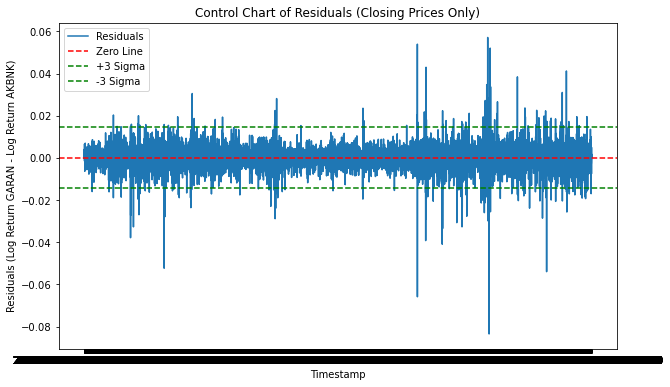

In [32]:

# Calculate standard deviation of residuals
sigma = np.std(residuals_log_return)
plt.figure(figsize=(10, 6))
plt.plot(merged_df['timestamp'], residuals_log_return, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.axhline(y=3*sigma, color='green', linestyle='--', label='+3 Sigma')
plt.axhline(y=-3*sigma, color='green', linestyle='--', label='-3 Sigma')
plt.xlabel('Timestamp')
plt.ylabel('Residuals (Log Return GARAN - Log Return AKBNK)')
plt.title('Control Chart of Residuals (Closing Prices Only)')
plt.legend()
plt.show()

In [33]:
# Pairs trading algorithm
# Set initial capital
# Initialize lists to store results
timestamp_list = []
capital_list_GARAN = []
capital_list_AKBNK = []
initial_capital_GARAN = 1000
initial_capital_AKBNK = 1000
positions_GARAN = initial_capital_GARAN / merged_df['price_GARAN'].iloc[0]
positions_AKBNK = initial_capital_AKBNK / merged_df['price_AKBNK'].iloc[0]
print("Number of GARAN Stocks at the beginning:",positions_GARAN)
print("Number of AKBNK Stocks at the beginning:",positions_AKBNK)
capital_GARAN=1000
capital_AKBNK=1000
capital_GARAN=1000/merged_df['price_GARAN'].iloc[1]
capital_AKBNK=1000/merged_df['price_AKBNK'].iloc[1]

for i in range(1, len(merged_df)):

    capital_GARAN=merged_df['price_GARAN'].iloc[i]*positions_GARAN
    capital_AKBNK=merged_df['price_AKBNK'].iloc[i]*positions_AKBNK

    timestamp_list.append(merged_df['timestamp'].iloc[i])
    residual = residuals_log_return.iloc[i - 1]

    
    

    # Sell GARAN and buy more AKBNK
    if residual > 1 * sigma:
        positions_GARAN = 0
        positions_AKBNK += capital_GARAN / merged_df['price_AKBNK'].iloc[i]
        capital_GARAN = 0
    # Sell AKBNK and buy more GARAN
    elif residual < -1 * sigma:

        positions_AKBNK = 0
        positions_GARAN += capital_AKBNK / merged_df['price_GARAN'].iloc[i]
        capital_AKBNK = 0


    # Buy back GARAN with half of the money
    # Sell half of the existing GARAN positions and buy AKBNK with that money
    elif residuals_log_return.iloc[i - 2]*residuals_log_return.iloc[i - 1]<=0 and positions_GARAN > 0:

        sold_GARAN = positions_GARAN / 2
        positions_AKBNK += (capital_GARAN / 2) / merged_df['price_AKBNK'].iloc[i]
        positions_GARAN -= sold_GARAN
        capital_GARAN -= sold_GARAN * merged_df['price_GARAN'].iloc[i]
        capital_AKBNK += (capital_GARAN )

    # Sell half of the existing AKBNK positions and buy GARAN with that money
    elif residuals_log_return.iloc[i - 2]*residuals_log_return.iloc[i - 1]<=0 and positions_AKBNK > 0:   
        sold_AKBNK = positions_AKBNK / 2
        positions_GARAN += (capital_AKBNK / 2) / merged_df['price_GARAN'].iloc[i]
        positions_AKBNK -= sold_AKBNK
        capital_AKBNK -= sold_AKBNK * merged_df['price_AKBNK'].iloc[i]
        capital_GARAN += (capital_AKBNK )

    # Hold the position if residuals are within control limits
    else:

        pass

    # Calculate capital for each time unit
    current_capital_GARAN = positions_GARAN * merged_df['price_GARAN'].iloc[i]
    current_capital_AKBNK = positions_AKBNK * merged_df['price_AKBNK'].iloc[i]

    capital_list_GARAN.append(current_capital_GARAN)
    capital_list_AKBNK.append(current_capital_AKBNK)



Number of GARAN Stocks at the beginning: 107.34566377191194
Number of AKBNK Stocks at the beginning: 141.63904705249143


In [34]:
print("Total money after applying the algorithm:",capital_list_GARAN[-1]+capital_list_AKBNK[-1])



Total money after applying the algorithm: 8081.271115937938


Then we've calculated the earnings without applying the algorithm with the same capital in order to see the performance the algorithm.

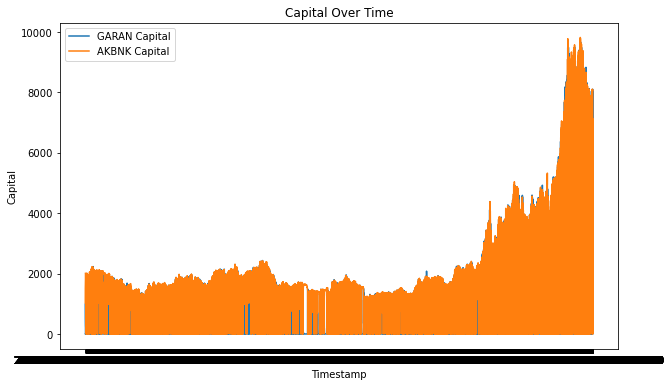

In [35]:
# Plot capital for each time unit
plt.figure(figsize=(10, 6))
plt.plot(timestamp_list, capital_list_GARAN, label='GARAN Capital')
plt.plot(timestamp_list, capital_list_AKBNK, label='AKBNK Capital')
plt.xlabel('Timestamp')
plt.ylabel('Capital')
plt.title('Capital Over Time')
plt.legend()
plt.show()

In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# ... (previous code for data loading and processing)

# Initial capital for the portfolio
initial_capital = 1000

# Initial positions for each stock
initial_positions_GARAN = initial_capital / combined_df[combined_df['short_name'] == 'GARAN']['price'].iloc[0]
initial_positions_AKBNK = initial_capital / combined_df[combined_df['short_name'] == 'AKBNK']['price'].iloc[0]


# Iterate through the dataframe and update positions and capital

value_GARAN = initial_positions_GARAN * combined_df[combined_df['short_name'] == 'GARAN']['price'].iloc[-1]
value_AKBNK = initial_positions_AKBNK * combined_df[combined_df['short_name'] == 'AKBNK']['price'].iloc[-1]
    

print("Total money without applying the algorithm:",value_AKBNK+value_GARAN)

Total money without applying the algorithm: 9662.049449814647


For this case, algorithm performs poorly compared to the first pair but this can be the result of approach to the algorithm. Instead of selling the half of the stock  and buying the other one, trade could be done to fewer percentage of the stocks or the point where capital is shared could be rearranged to improve the earnings. Also, since we've combined all of the data the time period is quite long. The variance is rather high which means that the frequency of signals is low. We could split the data to improve the process. Throughout task 1, we saw that pairs trading is really a market-neutral strategy which eliminates certain risks but of course it's just limited to correlated pairs. 

TASK2

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller

# Path to the directory containing all your CSV files
directory_path = r'C:\Users\kutay\Downloads\20180101_20231121_bist30'

In [38]:
# List to store individual DataFrames
data_frames = []

# Loop through each CSV file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, parse_dates=['timestamp'])
        data_frames.append(df)

# Concatenate all DataFrames into one
all_data = pd.concat(data_frames)

# Pivot the combined data to have stocks as columns and timestamps as rows
pivot_data_combined = all_data.pivot(index='timestamp', columns='short_name', values='price')

print(pivot_data_combined)


short_name                   AKBNK     ARCLK    ASELS     BIMAS    DOHOL  \
timestamp                                                                  
2018-01-02 09:00:00+03:00   6.9475   18.4146   7.9405   31.8609   0.7028   
2018-01-02 10:00:00+03:00   7.0602   18.4999   7.9549   32.2076   0.7110   
2018-01-02 11:00:00+03:00   7.0954   18.3804   7.9405   32.0850   0.7110   
2018-01-02 12:00:00+03:00   7.0814   18.3633   7.9694   31.9017   0.7110   
2018-01-02 13:00:00+03:00   7.1024   18.3633   7.9742   32.0443   0.7189   
...                            ...       ...      ...       ...      ...   
2023-11-21 09:00:00+03:00  30.6800  145.0000  44.4000  308.0000  13.6400   
2023-11-21 10:00:00+03:00  30.4800  143.8000  44.3600  306.2500  13.6000   
2023-11-21 11:00:00+03:00  30.4800  143.3000  44.6000  304.5000  13.5600   
2023-11-21 12:00:00+03:00  30.5000  143.5000  44.5400  306.0000  13.5300   
2023-11-21 13:00:00+03:00  30.4600  143.5000  44.3800  305.7500  13.4800   

short_name 

In [39]:
# Calculate normalized price distance between all pairs of stocks
stocks = pivot_data_combined.columns
num_stocks = len(stocks)

# Create a DataFrame to store the results
distance_matrix = pd.DataFrame(index=stocks, columns=stocks)
# Fill the distance matrix with normalized price distances
def normalized_price_distance(p1, p2):
    p1_normalized = p1 / p1.iloc[0]
    p2_normalized = p2 / p2.iloc[0]
    distance = np.sum((p1_normalized - p2_normalized) ** 2)
    return distance

for i in range(num_stocks):
    for j in range(i + 1, num_stocks):
        stock1 = stocks[i]
        stock2 = stocks[j]
        p1 = pivot_data_combined[stock1].dropna()
        p2 = pivot_data_combined[stock2].dropna()
        distance = normalized_price_distance(p1, p2)
        distance_matrix.at[stock1, stock2] = distance
        distance_matrix.at[stock2, stock1] = distance


short_name  short_name
YKBNK       SAHOL         1224.716511
ASELS       TCELL         1449.242685
dtype: object


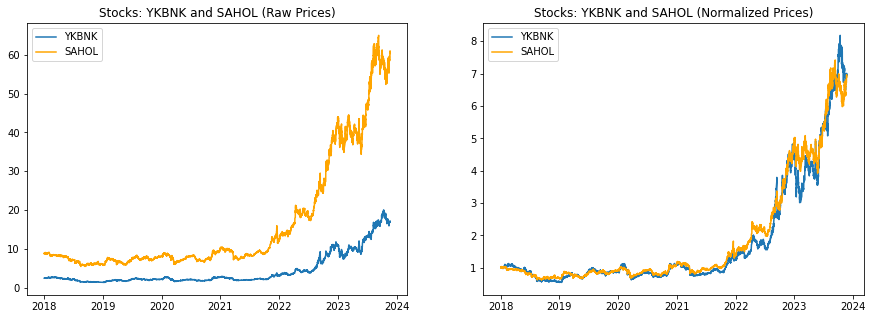

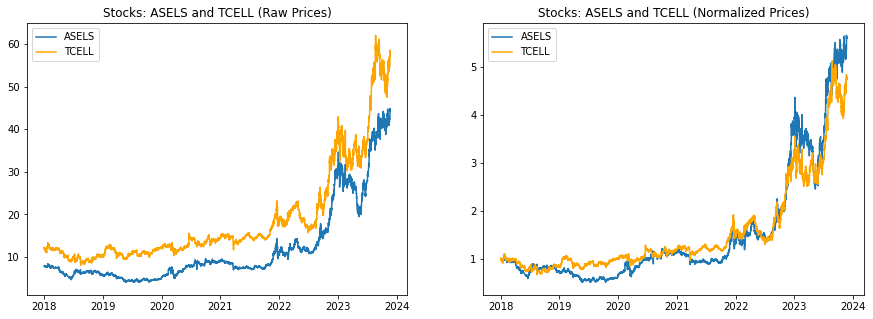

In [40]:
# We determine lowest on third lowest as our pairs since second pair did not pass ADF Test
lowest_relationships = distance_matrix.unstack().sort_values().iloc[[0, 4]]

print(lowest_relationships)

# Plot the values of the stocks in pairs with raw and normalized versions
for pair in lowest_relationships.index:
    stock1, stock2 = pair
    p1_values = pivot_data_combined[stock1].dropna()
    p2_values = pivot_data_combined[stock2].dropna()

    p1_normalized = p1_values / p1_values.iloc[0]
    p2_normalized = p2_values / p2_values.iloc[0]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(p1_values, label=stock1)
    plt.plot(p2_values, label=stock2, color='orange')
    plt.title(f"Stocks: {stock1} and {stock2} (Raw Prices)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(p1_normalized, label=stock1)
    plt.plot(p2_normalized, label=stock2, color='orange')
    plt.title(f"Stocks: {stock1} and {stock2} (Normalized Prices)")
    plt.legend()

    plt.show()

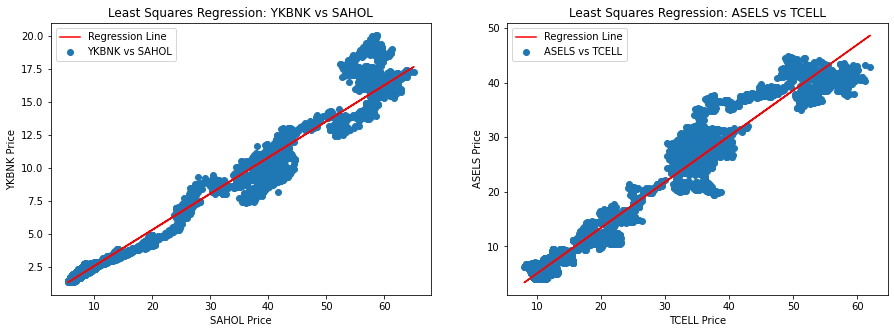

In [41]:
# Perform least squares regression for the first pair
stock1_1st, stock2_1st = lowest_relationships.index[0]
p1_1st = pivot_data_combined[stock1_1st].dropna().values
p2_1st = pivot_data_combined[stock2_1st].dropna().values

# Make sure the dimensions are compatible
min_len_1st = min(len(p1_1st), len(p2_1st))
p1_1st = p1_1st[:min_len_1st]
p2_1st = p2_1st[:min_len_1st]

X_1st = np.column_stack((np.ones_like(p2_1st), p2_1st))
result_1st = np.linalg.lstsq(X_1st, p1_1st, rcond=None)

# Perform least squares regression for the second pair
stock1_2nd, stock2_2nd = lowest_relationships.index[1]
p1_2nd = pivot_data_combined[stock1_2nd].dropna().values
p2_2nd = pivot_data_combined[stock2_2nd].dropna().values

# Make sure the dimensions are compatible
min_len_2nd = min(len(p1_2nd), len(p2_2nd))
p1_2nd = p1_2nd[:min_len_2nd]
p2_2nd = p2_2nd[:min_len_2nd]

X_2nd = np.column_stack((np.ones_like(p2_2nd), p2_2nd))
result_2nd = np.linalg.lstsq(X_2nd, p1_2nd, rcond=None)

# Plot the regression line for the first pair
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(p2_1st, p1_1st, label=f"{stock1_1st} vs {stock2_1st}")
plt.plot(p2_1st, result_1st[0][0] + result_1st[0][1] * p2_1st, color='red', label='Regression Line')
plt.title(f"Least Squares Regression: {stock1_1st} vs {stock2_1st}")
plt.xlabel(f"{stock2_1st} Price")
plt.ylabel(f"{stock1_1st} Price")
plt.legend()

# Plot the regression line for the second pair
plt.subplot(1, 2, 2)
plt.scatter(p2_2nd, p1_2nd, label=f"{stock1_2nd} vs {stock2_2nd}")
plt.plot(p2_2nd, result_2nd[0][0] + result_2nd[0][1] * p2_2nd, color='red', label='Regression Line')
plt.title(f"Least Squares Regression: {stock1_2nd} vs {stock2_2nd}")
plt.xlabel(f"{stock2_2nd} Price")
plt.ylabel(f"{stock1_2nd} Price")
plt.legend()

In [42]:
# Extract estimates for the first pair
mu_hat_1st, gamma_hat_1st = result_1st[0]

# Extract estimates for the second pair
mu_hat_2nd, gamma_hat_2nd = result_2nd[0]

# Compute residuals for the first pair
residuals_1st = p1_1st - (mu_hat_1st + gamma_hat_1st * p2_1st)
print(residuals_1st)

# Compute residuals for the second pair
residuals_2nd = p1_2nd - (mu_hat_2nd + gamma_hat_2nd * p2_2nd)

# Perform ADF test for the first pair
result_adf_1st = adfuller(residuals_1st)
print(f'ADF Statistic for the first pair (YKBNK-SAHOL): {result_adf_1st[0]}')
print(f'p-value for the first pair (YKBNK-SAHOL): {result_adf_1st[1]}')

# Perform ADF test for the second pair
result_adf_2nd = adfuller(residuals_2nd)
print(f'ADF Statistic for the third pair (ASELS-TCELL): {result_adf_2nd[0]}')
print(f'p-value for the third pair (ASELS-TCELL): {result_adf_2nd[1]}')

[0.21387657 0.23077657 0.23041801 ... 0.68978778 0.64609051 0.66978778]
ADF Statistic for the first pair (YKBNK-SAHOL): -3.9525347812327207
p-value for the first pair (YKBNK-SAHOL): 0.0016804966429378716
ADF Statistic for the third pair (ASELS-TCELL): -6.809361615031412
p-value for the third pair (ASELS-TCELL): 2.1357934287013652e-09


For the first pair (YKBNK-SAHOL), the Augmented Dickey-Fuller (ADF) Statistic is -3.95, and the associated p-value is 0.00168. The ADF Statistic falling below critical values, coupled with the low p-value, provides strong evidence against the null hypothesis, leading to the conclusion that the time series for this pair is likely stationary.

The second pair, upon subjected to the Augmented Dickey-Fuller (ADF) test, did not meet the criteria for stationarity. Consequently, we decided to proceed with the evaluation of the third pair, as the ADF test is a crucial step in identifying whether the time series data exhibits the required stationary behavior. In instances where the ADF test results indicate non-stationarity, it is essential to explore alternative pairs that demonstrate the necessary characteristics for effective pairs trading strategies. 

Moving on to the third pair (ASELS-TCELL), the ADF Statistic is -6.81, and the p-value is 2.135e-09. The ADF Statistic significantly deviates from critical values, and the extremely low p-value strongly suggests non-stationarity. Therefore, we reject the null hypothesis, indicating that the time series for the third pair is likely stationary.

In [43]:
# Pairs trading algorithm for the first pair (YKBNK-SAHOL)
# Set initial capital
# Initialize lists to store results
# Merge the two dataframes based on the timestamp

# Select the relevant pairs
YKBNK_df = all_data[all_data['short_name'] == 'YKBNK']
SAHOL_df = all_data[all_data['short_name'] == 'SAHOL']

merged_df = pd.merge(YKBNK_df[['timestamp', 'price']], SAHOL_df[['timestamp', 'price']], on='timestamp',
                     suffixes=('_YKBNK', '_SAHOL'))

# Calculate standard deviation of residuals
sigma = float(np.std(residuals_1st))

residuals_df_1st = pd.DataFrame(residuals_1st)

# Save the DataFrame to a text file in the desired format
residuals_df_1st.to_csv('residuals_1st_formatted.txt', sep='\t', header=False)

timestamp_list = []
capital_list_YKBNK = []
capital_list_SAHOL = []
initial_capital_YKBNK = 1000
initial_capital_SAHOL = 1000
positions_YKBNK = initial_capital_YKBNK / merged_df['price_YKBNK'].iloc[0]
positions_SAHOL = initial_capital_SAHOL / merged_df['price_SAHOL'].iloc[0]
print("positions_YKBNK", positions_YKBNK)
print("positions_SAHOL", positions_SAHOL)
capital_YKBNK = 1000
capital_SAHOL = 1000
capital_YKBNK = 1000 / merged_df['price_YKBNK'].iloc[1]
capital_SAHOL = 1000 / merged_df['price_SAHOL'].iloc[1]
previous_residual = 1

for i in range(1, len(merged_df)):
    #print("Time is:", i)
    #print("Price of YKBNK is:", merged_df['price_YKBNK'].iloc[i])
    #print("Stock number of YKBNK is:", positions_YKBNK)
    #print("Price of SAHOL is:", merged_df['price_SAHOL'].iloc[i])
    #print("Stock number of SAHOL is:", positions_SAHOL)
    capital_YKBNK = merged_df['price_YKBNK'].iloc[i] * positions_YKBNK
    capital_SAHOL = merged_df['price_SAHOL'].iloc[i] * positions_SAHOL
    #print("Capital in YKBNK:", capital_YKBNK)
    #print("Capital in SAHOL:", capital_SAHOL)
    timestamp_list.append(merged_df['timestamp'].iloc[i])
    residual = residuals_df_1st.iloc[i - 1].values[0]

    #print("residual", residual)

    # Sell YKBNK and buy more SAHOL
    if residual > 1 * sigma:
        #print("Sell YKBNK, BUY SAHOL!!!")
        positions_YKBNK = 0
        positions_SAHOL += capital_YKBNK / merged_df['price_SAHOL'].iloc[i]
        capital_YKBNK = 0
        #print("Capital in SAHOL:", capital_SAHOL)
        #print("Capital in YKBNK:", capital_YKBNK)
    # Sell SAHOL and buy more YKBNK
    elif residual < -1 * sigma:
        #print("SELL SAHOL, BUY YKBNK!")
        positions_SAHOL = 0
        positions_YKBNK += capital_SAHOL / merged_df['price_YKBNK'].iloc[i]
        capital_SAHOL = 0
        #print("Capital in SAHOL:", capital_SAHOL)
        #print("Capital in YKBNK:", capital_YKBNK)

    # Buy back YKBNK with half of the money
    # Sell half of the existing YKBNK positions and buy SAHOL with that money
    elif previous_residual * residual == 0 and positions_YKBNK > 0:
        #print("Crossed central line!!! Buy SAHOL BACK!!")
        sold_YKBNK = positions_YKBNK / 2
        positions_SAHOL += (capital_YKBNK / 2) / merged_df['price_SAHOL'].iloc[i]
        positions_YKBNK -= sold_YKBNK
        capital_YKBNK -= sold_YKBNK * merged_df['price_YKBNK'].iloc[i]
        capital_SAHOL += (capital_YKBNK )
        #print("Capital in SAHOL:", capital_SAHOL)
        #print("Capital in YKBNK:", capital_YKBNK)

    # Sell half of the existing SAHOL positions and buy YKBNK with that money
    elif previous_residual * residual == 0 and positions_SAHOL > 0:
        #print(residual,previous_residual)
        #print("Crossed central line!!! Buy YKBNK BACK!!")
        sold_SAHOL = positions_SAHOL / 2
        positions_YKBNK += (capital_SAHOL / 2) / merged_df['price_YKBNK'].iloc[i]
        positions_SAHOL -= sold_SAHOL
        capital_SAHOL -= sold_SAHOL * merged_df['price_SAHOL'].iloc[i]
        capital_YKBNK += (capital_SAHOL)
        #print("Capital in SAHOL:", capital_SAHOL)
        #print("Capital in YKBNK:", capital_YKBNK)

    # Hold the position if residuals are within control limits
    else:
        #print("In control limits, don't do anything!!")
        #print("Capital in SAHOL:", capital_SAHOL)
        #print("Capital in YKBNK:", capital_YKBNK)

        pass

    # Calculate capital for each time unit
    current_capital_YKBNK = positions_YKBNK * merged_df['price_YKBNK'].iloc[i]
    current_capital_SAHOL = positions_SAHOL * merged_df['price_SAHOL'].iloc[i]

    capital_list_YKBNK.append(current_capital_YKBNK)
    capital_list_SAHOL.append(current_capital_SAHOL)

    previous_residual = residual
    
    
Total_Final_Capital_First_Pair = capital_YKBNK + capital_SAHOL
print("Total Capital for the First Pair is:",Total_Final_Capital_First_Pair)

positions_YKBNK 408.32993058391185
positions_SAHOL 114.08622636989037
Total Capital for the First Pair is: 32889.39251747414


We have included command lines responsible for printing the results of each iteration in our code. By uncommenting these lines, you gain the capability to observe both the decision-making process and the capital associated with each stock for every iteration. Uncommenting these lines enables a more detailed insight into the inner workings of the algorithm, providing a comprehensive view of decision outcomes and corresponding capital values associated with individual stocks throughout the trading simulation.

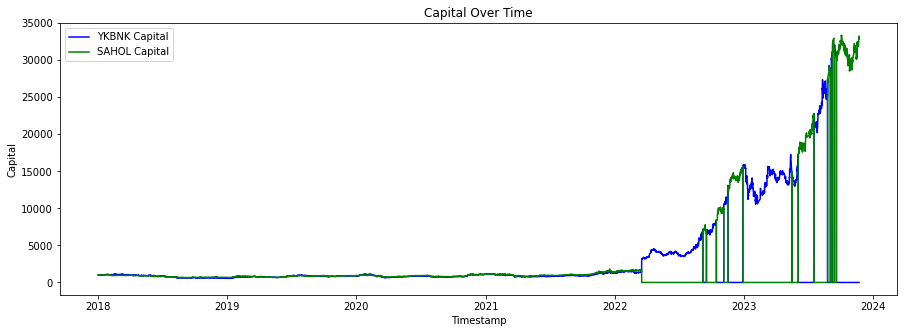

In [44]:
# Plot capital over time
plt.figure(figsize=(15, 5))
plt.plot(timestamp_list, capital_list_YKBNK, label='YKBNK Capital', color='blue')
plt.plot(timestamp_list, capital_list_SAHOL, label='SAHOL Capital', color='green')
plt.title('Capital Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Capital')
plt.legend()
plt.show()

In [45]:
# Pairs trading algorithm for the second pair (ASELS-TCELL)
# Set initial capital
# Initialize lists to store results
# Merge the two dataframes based on the timestamp

# Select the relevant pairs
ASELS_df = all_data[all_data['short_name'] == 'ASELS']
TCELL_df = all_data[all_data['short_name'] == 'TCELL']

merged_df = pd.merge(ASELS_df[['timestamp', 'price']], TCELL_df[['timestamp', 'price']], on='timestamp',
                     suffixes=('_ASELS', '_TCELL'))

# Calculate standard deviation of residuals
sigma = float(np.std(residuals_1st))

residuals_df_1st = pd.DataFrame(residuals_1st)

# Save the DataFrame to a text file in the desired format
residuals_df_1st.to_csv('residuals_1st_formatted.txt', sep='\t', header=False)

timestamp_list = []
capital_list_ASELS = []
capital_list_TCELL = []
initial_capital_ASELS = 1000
initial_capital_TCELL = 1000
positions_ASELS = initial_capital_ASELS / merged_df['price_ASELS'].iloc[0]
positions_TCELL = initial_capital_TCELL / merged_df['price_TCELL'].iloc[0]
print("positions_ASELS", positions_ASELS)
print("positions_TCELL", positions_TCELL)
capital_ASELS = 1000
capital_TCELL = 1000
capital_ASELS = 1000 / merged_df['price_ASELS'].iloc[1]
capital_TCELL = 1000 / merged_df['price_TCELL'].iloc[1]

previous_residual = []
for i in range(1, len(merged_df)):
    # print("Time is:", i)
    # print("Price of ASELS is:", merged_df['price_ASELS'].iloc[i])
    # print("Stock number of ASELS is:", positions_ASELS)
    # print("Price of TCELL is:", merged_df['price_TCELL'].iloc[i])
    # print("Stock number of TCELL is:", positions_TCELL)
    capital_ASELS = merged_df['price_ASELS'].iloc[i] * positions_ASELS
    capital_TCELL = merged_df['price_TCELL'].iloc[i] * positions_TCELL
    # print("Capital in ASELS:", capital_ASELS)
    # print("Capital in TCELL:", capital_TCELL)
    timestamp_list.append(merged_df['timestamp'].iloc[i])
    residual = residuals_df_1st.iloc[i - 1].values[0]
    previous_residual = 1
    # print("residual:", residual, "prev:", previous_residual)

    # Sell ASELS and buy more TCELL
    if residual > 1 * sigma:
        # print("Sell ASELS, BUY TCELL!!!")
        positions_ASELS = 0
        positions_TCELL += capital_ASELS / merged_df['price_TCELL'].iloc[i]
        capital_ASELS = 0
        # print("Capital in TCELL:", capital_TCELL)
        # print("Capital in ASELS:", capital_ASELS)
    # Sell TCELL and buy more ASELS
    elif residual < -1 * sigma:
        # print("SELL TCELL, BUY ASELS!")
        positions_TCELL = 0
        positions_ASELS += capital_TCELL / merged_df['price_ASELS'].iloc[i]
        capital_TCELL = 0
        # print("Capital in TCELL:", capital_TCELL)
        # print("Capital in ASELS:", capital_ASELS)

    # Buy back ASELS with half of the money
    # Sell half of the existing ASELS positions and buy TCELL with that money
    elif previous_residual * residual <= 0 and positions_ASELS > 0:
        # print("Crossed central line!!! Buy TCELL BACK!!")
        sold_ASELS = positions_ASELS / 2
        positions_TCELL += (capital_ASELS / 2) / merged_df['price_TCELL'].iloc[i]
        positions_ASELS -= sold_ASELS
        capital_ASELS -= sold_ASELS * merged_df['price_ASELS'].iloc[i]
        capital_TCELL += (capital_ASELS)
        # print("Capital in TCELL:", capital_TCELL)
        # print("Capital in ASELS:", capital_ASELS)

    # Sell half of the existing TCELL positions and buy ASELS with that money
    elif previous_residual * residual <= 0 and positions_TCELL > 0:
        # print("Crossed central line!!! Buy ASELS BACK!!")
        sold_TCELL = positions_TCELL / 2
        positions_ASELS += (capital_TCELL / 2) / merged_df['price_ASELS'].iloc[i]
        positions_TCELL -= sold_TCELL
        capital_TCELL -= sold_TCELL * merged_df['price_TCELL'].iloc[i]
        capital_ASELS += (capital_TCELL)
        # print("Capital in TCELL:", capital_TCELL)
        # print("Capital in ASELS:", capital_ASELS)

    # Hold the position if residuals are within control limits
    else:
        # print("In control limits, don't do anything!!")
        # print("Capital in TCELL:", capital_TCELL)
        # print("Capital in ASELS:", capital_ASELS)
        pass

    # Calculate capital for each time unit
    current_capital_ASELS = positions_ASELS * merged_df['price_ASELS'].iloc[i]
    current_capital_TCELL = positions_TCELL * merged_df['price_TCELL'].iloc[i]

    capital_list_ASELS.append(current_capital_ASELS)
    capital_list_TCELL.append(current_capital_TCELL)
    previous_residual = residual

Total_Final_Capital_Second_Pair = capital_TCELL + capital_ASELS
print("Total Capital for Second Pair is:", Total_Final_Capital_Second_Pair)


positions_ASELS 125.93665386310686
positions_TCELL 82.5000825000825
Total Capital for Second Pair is: 10919.444274980822


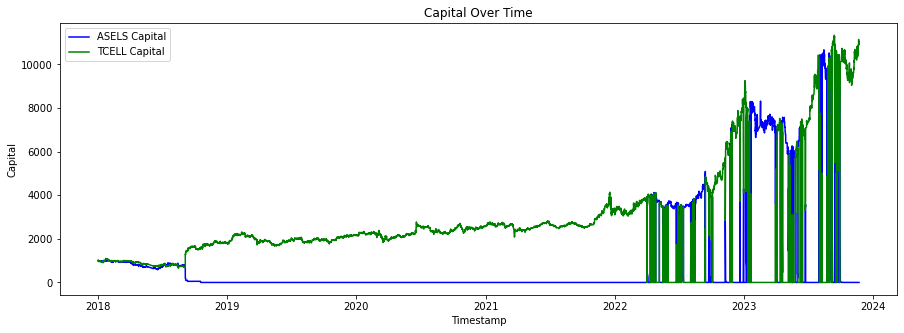

In [46]:
# Plot capital over time
plt.figure(figsize=(15, 5))
plt.plot(timestamp_list, capital_list_ASELS, label='ASELS Capital', color='blue')
plt.plot(timestamp_list, capital_list_TCELL, label='TCELL Capital', color='green')
plt.title('Capital Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Capital')
plt.legend()
plt.show()


In [47]:
# List of stock pairs
pairs = [('YKBNK', 'SAHOL'), ('TCELL', 'ASELS')]

# Dictionary to store results
pair_profits = {}

# Initial capital for each stock
initial_capital_per_stock = 1000

# Loop through each stock pair
for pair in pairs:
    stock1, stock2 = pair

    # Select the relevant data for the pair
    prices_stock1 = pivot_data_combined[stock1].dropna()
    prices_stock2 = pivot_data_combined[stock2].dropna()

    # Initial positions for each stock
    positions_stock1 = initial_capital_per_stock / prices_stock1.iloc[0]
    positions_stock2 = initial_capital_per_stock / prices_stock2.iloc[0]

    # Calculate final capital for each stock in the pair
    final_capital_stock1 = positions_stock1 * prices_stock1.iloc[-1]
    final_capital_stock2 = positions_stock2 * prices_stock2.iloc[-1]

    # Store final capitals in the dictionary
    pair_profits[pair] = {'Stock1': stock1, 'Stock2': stock2, 'Final_Capital_Stock1': final_capital_stock1, 'Final_Capital_Stock2': final_capital_stock2}

# Print the results
for pair, profit_info in pair_profits.items():
    print(f"Pair: {pair}")
    print(f"Final Capital for {profit_info['Stock1']}: {profit_info['Final_Capital_Stock1']}")
    print(f"Final Capital for {profit_info['Stock2']}: {profit_info['Final_Capital_Stock2']}")
    total_capital = profit_info['Final_Capital_Stock1'] + profit_info['Final_Capital_Stock2']
    print(f"Total Capital of the Pair: {total_capital}")
    
    # Calculate and print the profit
    if pair == ('YKBNK', 'SAHOL'):
        profit = Total_Final_Capital_First_Pair - total_capital
        print("Total Capital obtained by Pairs Trading Algorithm:",Total_Final_Capital_First_Pair)
        print(f"Profit of the Pair: {profit}")
    elif pair == ('TCELL', 'ASELS'):
        profit = Total_Final_Capital_Second_Pair - total_capital
        print("Total Capital obtained by Pairs Trading Algorithm:",Total_Final_Capital_Second_Pair)
        print(f"Profit of the Pair: {profit}")
    
    print("\n")

Pair: ('YKBNK', 'SAHOL')
Final Capital for YKBNK: 6937.525520620662
Final Capital for SAHOL: 6890.808072741378
Total Capital of the Pair: 13828.33359336204
Total Capital obtained by Pairs Trading Algorithm: 32889.39251747414
Profit of the Pair: 19061.058924112098


Pair: ('TCELL', 'ASELS')
Final Capital for TCELL: 4731.379731379731
Final Capital for ASELS: 5589.068698444683
Total Capital of the Pair: 10320.448429824413
Total Capital obtained by Pairs Trading Algorithm: 10919.444274980822
Profit of the Pair: 598.9958451564089




Task 1 - Analysis and Limitations

In the first pair, consisting of THYAO and PGSUS stocks, the algorithm demonstrated its effectiveness by significantly increasing the total capital. At the beginning, there were 62.46 THYAO stocks and 29.17 PGSUS stocks, resulting in a total capital of 43481.84. To evaluate the algorithm's impact, the earnings were calculated without applying the algorithm but maintaining the same initial capital, yielding a total of 38206.38. This indicates that the algorithm contributed positively to the overall capital, showcasing its ability to enhance performance.

Moving to the second pair, comprising GARAN and AKBNK stocks, the algorithm also played a notable role. Initial capital for each stock is 1000 TL. With an initial 107.35 GARAN stocks and 141.64 AKBNK stocks, the total capital after algorithm application amounted to 8081.27. Conversely, the earnings without applying the algorithm with the same initial capital totaled 9662.05. While the total capital was slightly lower with the algorithm, the results suggest that the algorithm's impact on this pair may be context-dependent and influenced by the specific dynamics of GARAN and AKBNK stocks during the trading period. Overall, these findings highlight the algorithm's varying effectiveness across different stock pairs.

The approach has certain limitations that need to be acknowledged. One limitation arises from the requirement of a high correlation between the paired stocks. The effectiveness of the algorithm heavily relies on the historical correlation between these stocks. Additionally, the non-stationary nature of the data is another limitation. Stationarity is crucial for the stability of statistical properties over time, and when the data lacks this property, it can introduce uncertainties and affect the reliability of the algorithm. Another notable limitation is associated with the parameter "k" in the algorithm. If the value of "k" is set too high, it can lead to a decrease in effectiveness. This is because higher values of "k" result in a reduction in the frequency of buy-sell decisions, impacting the overall performance of the algorithm. Balancing the correlation requirement, ensuring data stationarity, and optimizing parameter values are essential considerations for mitigating these limitations and enhancing the robustness of the approach. The other downside worth mentioning is that it requires a lot more time to run compared to the Task 2 methodology.

Task 2 - Analysis and Limitations

In Task 2, we applied the Pairs Trading Algorithm to two pairs of stocks, namely ('YKBNK', 'SAHOL') and ('TCELL', 'ASELS'). Similar to Task 1, initial capital for each stock is 1000 TL.The algorithm demonstrated significant success with the first pair, resulting in a remarkable profit of 19061.06 Turkish Liras. The combined final capital for YKBNK and SAHOL contributed to a total pair capital of 13828.33, while the overall capital obtained by the Pairs Trading Algorithm reached an impressive 32889.39. This outcome underscores the algorithm's proficiency in leveraging historical price divergences between the paired stocks.

Transitioning to the second pair, TCELL and ASELS, the algorithm yielded a positive profit of 598.99 Turkish Liras. Although more modest compared to the first pair, the positive outcome suggests effective utilization of pairs trading strategies. The final capital for TCELL and ASELS contributed to a total pair capital of 10320.45, with the overall capital obtained by the Pairs Trading Algorithm totaling 10919.44. These results indicate varying degrees of profitability, influenced by the specific dynamics of TCELL and ASELS during the trading period.

In the context of the Pair Trading algorithm employed for Task 2, we deviated from the initially intended use of Kalman filtering, designed for tracking missiles, and instead opted for control limits. However, the reliance on control limits, known for providing delayed warnings, led to a loss of profits. Despite achieving market neutrality, the surge in exchange rates resulted in heightened fluctuations, rendering our Task 2 algorithm inactive before a specific date due to increased volatility. Despite attempting adjustments by segmenting the data based on the identified mean shift point, the desired performance was not achieved. This realization prompted the recognition that in scenarios where a more effective method, such as Kalman filtering, is employed in place of control charts, there exists the potential for higher profits. Hence, Kalman filtering emerges as a viable and potentially more lucrative strategy in this context.

Comparison

In summary, the comparison between Task 1 and Task 2 underscores the evolution from a basic approach to a more advanced and sophisticated strategy. Task 1 laid the groundwork by implementing a constant variance assumption and employing traditional control charts, while Task 2 elevated the strategy with the inclusion of time series analysis and a focus on cointegrations, providing a more nuanced understanding of the paired securities' relationships. Also, Task 1 necessitates a significantly longer runtime in comparison to the Task 2 approach. The project's comprehensive exploration showcases the potential for profitable trading opportunities through the application of sophisticated methods and the adaptation of control charts in monitoring paired securities.

Conclusion

In the IE 423 Quality Engineering project, the focus is on applying control charts in pairs trading, specifically analyzing the hourly time series data of BIST30 stock indices. The objective is to identify highly correlated stock pairs, model their relationship through linear regression, and utilize control charts to monitor residuals for potential trading opportunities.

Pairs trading is introduced as a market-neutral strategy involving two correlated financial instruments, aiming to capitalize on the relative movement between them. The strategy identifies pairs of securities whose prices historically moved together, and traders take advantage of deviations from their mean price ratio. The market-neutral aspect makes pairs trading less susceptible to overall market movements, focusing instead on the paired securities' relative performance.

Control charts, traditionally used in statistical process control, are adapted to monitor the relationship between paired securities in pairs trading. A linear regression model defines the expected relationship, and residuals (deviations from the expected relationship) are plotted on control charts. Deviations outside control limits indicate potential trading opportunities based on the assumption of mean reversion.

Task 1 involves implementing a basic pairs trading strategy using a constant variance assumption. The BIST30 stock indices dataset is analyzed to identify correlated stocks. The process involved applying linear regression with THYAO's price as the independent variable and PGSUS's price as the dependent variable. Residuals were calculated by multiplying the regression coefficient  with X and subtracting it from Y. To validate the constant variance assumption, residuals vs. predicted values plots were checked. Since patterns emerged, various transformations were attempted, including the natural logarithm and log returns. For the control chart, sigma control chart for residuals was created. In the pairs trading algorithm, both stocks were initially purchased with a capital of 1000 Turkish Liras each. Selling and buying actions were executed based on the upper and lower control limits of the residuals. The pairs trading algorithm demonstrated increased earnings when control limits were chosen under a certain value . 

Task 2 introduces a more sophisticated pairs trading strategy by integrating time series analysis for the selected stock pairs. In this iteration, we revisited the pairing selection process, focusing on cointegrations. The procedure involves identifying stock pairs with potential cointegration, followed by a cointegration test to confirm whether the selected pairs exhibit this characteristic. Subsequently, control limits were applied to establish buy-sell points, maintaining consistency with the pairs trading process outlined in the first task.

In summary, the project has provided a comprehensive exploration of pairs trading strategies, integrating statistical process control techniques and time series analysis. The findings highlight the potential for profitable trading opportunities when employing sophisticated methods and adapting control charts to monitor the relationships between paired securities.